# Bone Metastasis Classification using Base CNN

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchstat import stat

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Set seed for random number generation to create reproducible results
random_seed = 5
torch.manual_seed(random_seed)

In [3]:
# Transformations to apply to inputs
preprocess = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor(),
    # Resize to 256 x 256
    transforms.Resize((256, 256))
])

In [4]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Load Data

In [5]:
data_dir = r"dataset-sample-flat"

In [6]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [7]:
# Dataset and dataloader for training data
dataset = CustomDataset(img_dir=data_dir, transform=preprocess)
labels = list(dataset.img_labels.iloc[:, 1])

### Define Model

In [8]:
# Model hyperparameters; epochs & batch size from Magboo & Abu
epochs = 2 # TODO: Change to 100
batch_size = 16

In [9]:
channels = 3

# Create model with CNN and MLP for classification
class CNN(nn.Module):
    # Define layers
    def __init__(self):
        super().__init__()
        # TODO: Implement filters in convolutions
        self.conv2d_1 = nn.Conv2d(in_channels = channels, out_channels = 8, kernel_size = 3)
        self.max_pooling2d_1 = nn.MaxPool2d(kernel_size = 2)
        self.dropout_1 = nn.Dropout(0.2)
        self.conv2d_2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)
        self.max_pooling2d_2 = nn.MaxPool2d(kernel_size = 2)
        self.dropout_2 = nn.Dropout(0.2)
        self.conv2d_3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)
        self.max_pooling2d_3 = nn.MaxPool2d(kernel_size = 2)
        self.dropout_3 = nn.Dropout(0.2)
        self.dropout_4 = nn.Dropout(0.2)
        self.dense_1 = nn.Linear(in_features = 28800, out_features = 64)
        self.dense_2 = nn.Linear(in_features = 64, out_features = 2)

    # Apply layers
    def forward(self, x):
        # Convolution layers
        x = F.relu(self.conv2d_1(x))
        x = self.max_pooling2d_1(x)
        x = self.dropout_1(x)
        x = F.relu(self.conv2d_2(x))
        x = self.max_pooling2d_2(x)
        x = self.dropout_2(x)
        x = F.relu(self.conv2d_3(x))
        x = self.max_pooling2d_3(x)
        x = self.dropout_3(x)
        
        # Flatten all dimensions except batch
        x = torch.flatten(input = x, start_dim = 1)
        
        # Classification layers
        x = self.dropout_4(x)
        x = F.relu(self.dense_1(x))
        x = torch.sigmoid(self.dense_2(x))
        return x

In [10]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [11]:
# Instantiate model
model = CNN().to(device)

In [12]:
# Define criterion (function used to compute loss) and optimizer for model
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Train Model

In [13]:
# Split data into training and test sets
train_set, test_set = train_test_split(dataset, train_size=0.8, random_state=random_seed, shuffle=True, stratify=labels)

image_datasets = {
    'train': train_set,
    'test': test_set
}

In [14]:
# Get DataLoaders for training and test sets
dataloaders = {
    'train':
    torch.utils.data.DataLoader(train_set,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(test_set,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0)
}

In [15]:
train_losses = []
test_losses = []

In [16]:
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [17]:
model_trained = train_model(model, criterion, optimizer, epochs)

Epoch 1/2
----------
train loss: 0.6669, acc: 0.6562
test loss: 0.6646, acc: 0.6500
Epoch 2/2
----------
train loss: 0.6444, acc: 0.6562
test loss: 0.6563, acc: 0.6500


### Save Model

In [18]:
# Print tensor sizes per layer in model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv2d_1.weight 	 torch.Size([8, 3, 3, 3])
conv2d_1.bias 	 torch.Size([8])
conv2d_2.weight 	 torch.Size([16, 8, 3, 3])
conv2d_2.bias 	 torch.Size([16])
conv2d_3.weight 	 torch.Size([32, 16, 3, 3])
conv2d_3.bias 	 torch.Size([32])
dense_1.weight 	 torch.Size([64, 28800])
dense_1.bias 	 torch.Size([64])
dense_2.weight 	 torch.Size([2, 64])
dense_2.bias 	 torch.Size([2])


In [19]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(20.), 'exp_avg': tensor([[[[-3.9181e-03, -3.9173e-03, -3.9226e-03],
          [-3.9230e-03, -3.9281e-03, -3.9317e-03],
          [-3.9626e-03, -3.9627e-03, -3.9608e-03]],

         [[-3.9181e-03, -3.9173e-03, -3.9226e-03],
          [-3.9230e-03, -3.9281e-03, -3.9317e-03],
          [-3.9626e-03, -3.9627e-03, -3.9608e-03]],

         [[-3.9181e-03, -3.9173e-03, -3.9226e-03],
          [-3.9230e-03, -3.9281e-03, -3.9317e-03],
          [-3.9626e-03, -3.9627e-03, -3.9608e-03]]],


        [[[ 5.3250e-04,  5.3174e-04,  5.3005e-04],
          [ 5.2787e-04,  5.2826e-04,  5.2735e-04],
          [ 5.2029e-04,  5.2097e-04,  5.1446e-04]],

         [[ 5.3250e-04,  5.3174e-04,  5.3005e-04],
          [ 5.2787e-04,  5.2826e-04,  5.2735e-04],
          [ 5.2029e-04,  5.2097e-04,  5.1446e-04]],

         [[ 5.3250e-04,  5.3174e-04,  5.3005e-04],
          [ 5.2787e-04,  5.2826e-04,  5.2735e-04],
          [ 5.2029e-04,  5.2097e-04,  5.1446e-04]]],

In [20]:
torch.save(model.state_dict(), 'weights/base_weights.h5')

### Evaluate Model

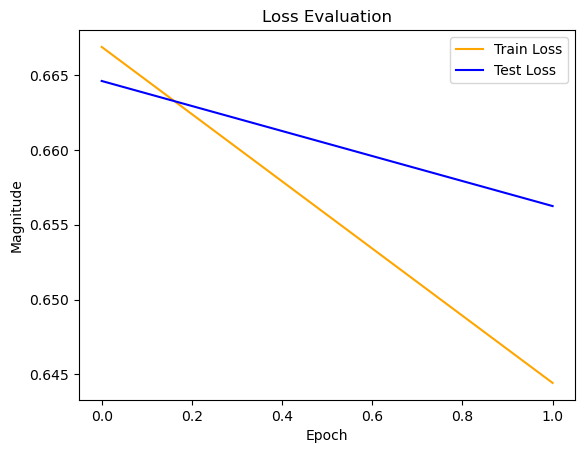

In [21]:
# Plot losses
ax = plt.axes()
plt.plot(train_losses, color='orange')
plt.plot(test_losses, color='blue')
plt.title('Loss Evaluation')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [22]:
# Evaluation for this fold
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
total = 0
    
with torch.no_grad():
    for batch_index, batch_data in enumerate(dataloaders['test']):
        # Get the inputs; data is a list of [images, labels]
        images, labels = batch_data

        # Forward pass
        predictions = model(images)

        # Set total and correct
        _, predicted = torch.max(input=predictions, dim=1) # Get list of predicted classes
            
        # Get how many classes there were in this batch
        total += labels.size(0)
            
        # Get true positive, true negative, false positive, and false negative counts
        for index in range(len(labels)):
            true_pos = true_pos+1 if (predicted[index] == 1 and labels[index] == 1) else true_pos
            true_neg = true_neg+1 if (predicted[index] == 0 and labels[index] == 0) else true_neg
            false_pos = false_pos+1 if (predicted[index] == 1 and labels[index] == 0) else false_pos
            false_neg = false_neg+1 if (predicted[index] == 0 and labels[index] == 1) else false_neg
    
print(f"TP: {true_pos}, TN: {true_neg}, FP: {false_pos}, FN: {false_neg}, total: {total}")
print("Final Performance Metrics")
    
# Get evaluation metrics
# accuracy: (tp + tn) / (p + n)
accuracy = (true_pos + true_neg)/total if total != 0 else 0
print(f"Accuracy: {accuracy}")
    
# precision tp / (tp + fp)
precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) != 0 else 0
print(f"Precision: {precision}")
    
# sensitivity: tp / (tp + fn)
sensitivity = true_pos/(true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
print(f"Sensitivity: {sensitivity}")
    
# specificity: tn / (tn + fp)
specificity = true_neg/(true_neg + false_pos) if (true_neg + false_pos) != 0 else 0
print(f"Specificity: {specificity}")
    
# f1: 2(precision * recall)/(precision + recall)
f1 = 2 * (precision * sensitivity)/(precision + sensitivity) if (precision + sensitivity) != 0 else 0
print(f"F1: {f1}")

TP: 0, TN: 26, FP: 0, FN: 14, total: 40
Final Performance Metrics
Accuracy: 0.65
Precision: 0
Sensitivity: 0.0
Specificity: 1.0
F1: 0


In [23]:
# Get computational complexity
stat(model, (3, 256, 256))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
           module name  input shape output shape     params memory(MB)           MAdd         Flops  MemRead(B)  MemWrite(B) duration[%]   MemR+W(B)
0             conv2d_1    3 256 256    8 254 254      224.0       1.97   27,870,912.0  14,451,584.0    787328.0    2064512.0      23.55%   2851840.0
1      max_pooling2d_1    8 254 254    8 127 127        0.0       0.49      387,096.0     516,128.0   2064512.0     516128.0      23.45%   2580640.0
2            dropout_1    8 127 127    8 127 127        0.0       0.49            0.0           0.0         0.0          0.0      11.

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


### Show Predictions on Sample Images

In [24]:
sample_img_names = ["0000-0-A.tif", "0163-0-P.tif", "0198-0-A.tif"]
sample_img_paths = [(data_dir + "/" + sample_img_names[i]) for i in range(len(sample_img_names))]
sample_classes = [sample_img_names[i][5] for i in range(len(sample_img_names))]
sample_ground_truths = ["No Metastasis" if sample_classes[i] == 0 else "Metastasis" for i in range(len(sample_img_names))]
sample_imgs = [Image.open(img_path).convert('RGB') for img_path in sample_img_paths]
sample_imgs_show = [Image.open(img_path) for img_path in sample_img_paths]

In [25]:
validation_batch = torch.stack([preprocess(img).to(device) for img in sample_imgs])

In [26]:
sample_preds= model(validation_batch).detach().cpu().data.numpy()
sample_preds

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!


array([[0.6783608 , 0.33579916],
       [0.6775365 , 0.3367777 ],
       [0.6754511 , 0.33907855]], dtype=float32)

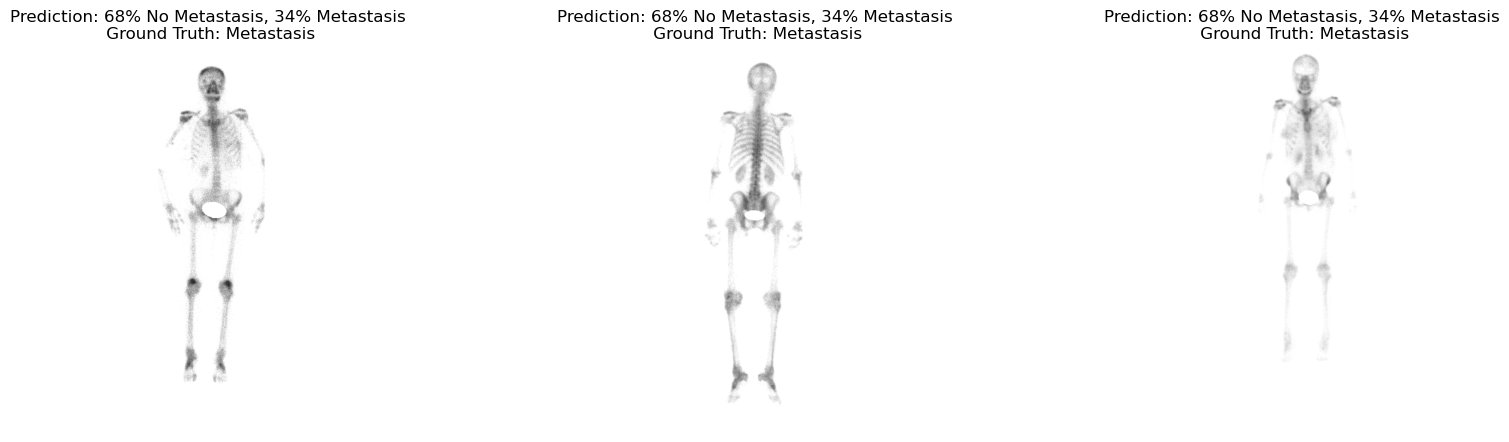

In [27]:
fig, axs = plt.subplots(1, len(sample_imgs_show), figsize=(20, 5))
for i, img in enumerate(sample_imgs_show):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis\n Ground Truth: {}"
                 .format(100*sample_preds[i,0], 100*sample_preds[i,1], sample_ground_truths[i]))
    ax.imshow(img)